## Model development for Legacy model
- Train word embeddings from scratch

In [1]:
!pip install nltk
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.2 MB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 898 kB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 25.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from build_model import *

# features = feature_extractions("Flickr8k_Dataset")

# #save features for future use.
# with open("features.pkl", "wb") as f:
#    dump(features, f)

In [3]:
with open("Flickr8k_text/Flickr8k.token.txt", "r") as f:
    raw_caption = f.read()

caption_dict = caption_dictionary(raw_caption)
caption_dict = caption_cleaning(caption_dict)

#Save the caption_dict for future use
with open("captions.pkl", "wb") as f:
    dump(caption_dict, f)

In [4]:
train = dataset("Flickr8k_text/Flickr_8k.trainImages.txt")
dev = dataset("Flickr8k_text/Flickr_8k.devImages.txt")
test = dataset("Flickr8k_text/Flickr_8k.testImages.txt")

train_caption_dict = load_captions(train, 1)
train_features = load_features(train)
dev_caption_dict = load_captions(dev, 1)
dev_features = load_features(dev)
test_caption_dict = load_captions(test, 0)
test_features = load_features(test)

#Initialize the tokenizer
vocab_size = 3001
tokenizer = create_tokenizer(train_caption_dict, num_vocab=vocab_size)

#Save the tokenizer for caption_generation
with open("../tokenizer.json", "w") as f:
    json.dump(tokenizer.to_json(), f)

print("vocab size: {}".format(vocab_size))
max_length = max([len(c.split()) for c in caption_to_list(train_caption_dict)]) - 1 #Maximum length of input sequence
print("max length: {}".format(max_length))

vocab size: 3001
max length: 37


In [5]:
path_to_glove_file = "./glove.6B/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

#Initialize embedding matrix
embed_dim = 100
embedding_matrix = np.zeros((vocab_size, embed_dim))
coverage = set()
for i in range(1, vocab_size):
    w = tokenizer.index_word[i]
    if w in embeddings_index.keys():
        embedding_matrix[i] = embeddings_index.get(w) #use the pre-trained embeddings, set 0 otherwise
        coverage.add(w)

oov = check_coverage(tokenizer, coverage, vocab_size=vocab_size)
print(oov)

Coverage in vocab: 0.9866711096301233
Coverage in word_count: 0.8398431905107979
{'<startseq>': 30000, '<endseq>': 30000, 'tshirt': 125, 'snowcovered': 36, 'rollerblader': 16, 'merrygoround': 13, 'upsidedown': 12, 'waterskier': 10, 'floaties': 10, 'tshirts': 8, 'africanamerican': 8, 'bicycler': 8, 'tugofwar': 7, 'outstreached': 7, 'offcamera': 7, 'darkskinned': 7, 'brownhaired': 7, 'darkhaired': 6, 'hulahoops': 6, 'wakeboarder': 6, 'midjump': 6, 'treelined': 5, 'threewheeled': 5, 'hiviz': 5, 'wakeboards': 5, 'corndogs': 5, 'somthing': 4, 'blackandwhite': 4, 'dalmation': 4, 'facepaint': 4, 'plushie': 4, 'grayhaired': 4, 'fourwheeler': 4, 'fencedin': 4, 'lightcolored': 4, 'surfboarder': 4, 'redhaired': 4, 'stripy': 4, 'longnecked': 4}


In [6]:
num_epoches = 10
num_photos = 32 #photos per batch

steps_per_epoch = int(len(train_caption_dict) / num_photos)
val_steps = int(len(dev_caption_dict) / num_photos)

model = define_model(max_length, vocab_size, dp_rate=0.1, embed_size=embed_dim, embedding_matrix=None)

train_generator = generate_dataset(train_caption_dict, train_features, tokenizer, max_length, vocab_size, num_photos)
dev_generator = generate_dataset(dev_caption_dict, dev_features, tokenizer, max_length, vocab_size, num_photos)

for i in range(num_epoches):
    for step in range(5*steps_per_epoch):
        X, Y = next(train_generator)
        model.train_on_batch(X, Y)
    
    model.save("../model/model_v{i}.h5".format(i=i))
    print("finish saving model: model_v{i}".format(i=i))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           262208      dropout[0][0]                    

BLEU Score on Test Set: 0.58, 0.39, 0.29, 0.16
CPU times: user 5min 31s, sys: 28.9 s, total: 6min
Wall time: 3min 7s


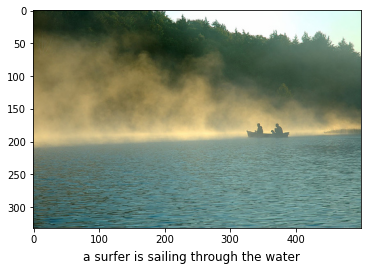

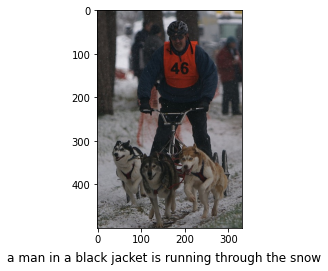

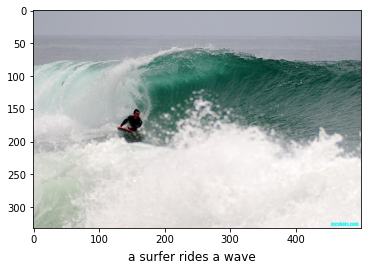

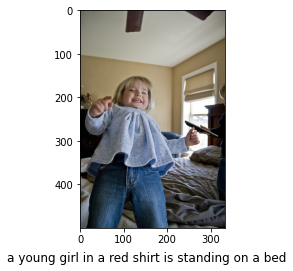

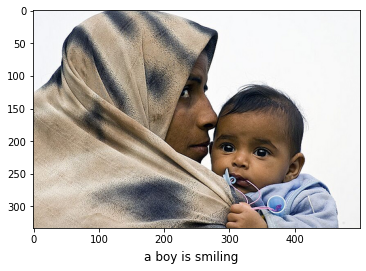

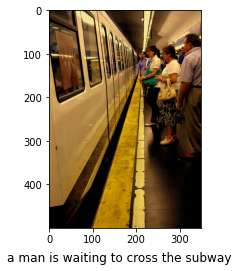

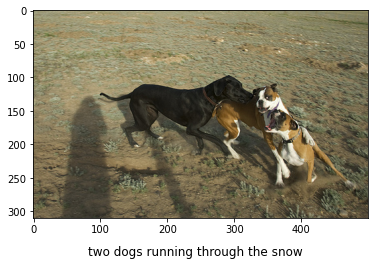

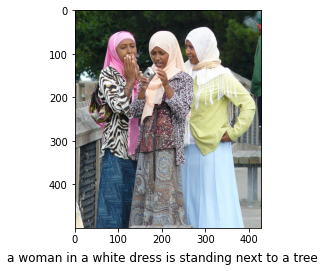

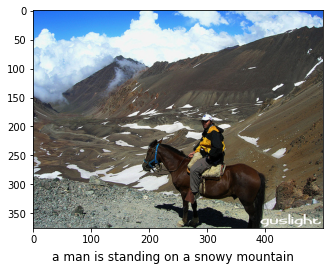

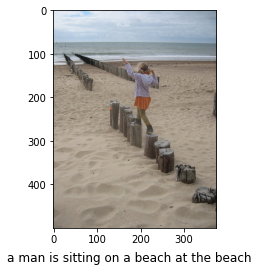

In [8]:
%%time
evaluate_model(model, tokenizer, test_caption_dict, test_features, max_length, vocab_size)